In [0]:
import os
import warnings
import wave
import random

import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pydub import AudioSegment
from scipy.io import wavfile
import itertools

warnings.filterwarnings("ignore")

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ROOT = 'drive/My Drive/MASR-master/'
DATA = ROOT + 'data/'
PROCESSED_DATA = ROOT + 'processed_data/'
PREFERED_FILE_FORMAT = 'wav'

In [103]:
os.listdir(PROCESSED_DATA)

['3', '2', '1', '4', '5']

In [104]:
data_file_paths = sorted([DATA+f for f in os.listdir(path=DATA)])

file_formats = set([f.split('.')[1]
                    for path in data_file_paths for f in os.listdir(path=path)])

print('file are -', file_formats.__str__()[1:-1], '- formats')

file are - 'mp3', 'mp4', 'wav', 'm4a', 'aac' - formats


##### Install depenencies (tested on ubuntu 19.10)
!pip install pydub
<br>
!apt-get install ffmpeg
<br>
!pip install librosa

In [0]:
"""ALL PATHS ARE FROM MASR DIRECTORY"""


def to_wav(src, dst):
    """ Convert single file to .wav
        Params:
        src - (str) full path to file to convert
        dst - (str) full path and file name where to store converted 
    """
    type_ = src.split('.')[1]
    sound = AudioSegment.from_file(src, type_)
    sound.export(dst, format=PREFERED_FILE_FORMAT)


def convert_all_files_to_wav(src_dir, dst_dir):
    """ Convert all files in dir_name directory
        to .wav formats

        Params:
        src_dir - (str) directory from where to convert files
        dst_dir - (str) directory to where to store converted files

    """
    unconvertables = []
    for fname in os.listdir(path=src_dir):
        src = src_dir + '/' + fname
        dst = dst_dir + '/' + fname.split('.')[0] + '.' + PREFERED_FILE_FORMAT
        try:
            to_wav(src, dst)
        except:
            unconvertables.append(src)
    return unconvertables


def convert_all_folders_to_wav(sound_dirs):
    """ Converts all files from all sound directories

        Params:
        sound_dirs - (list of strs) all dir paths from where to convert
    """
    all_unconvertables = []
    for dir_name in sound_dirs:
        src_dir = DATA + dir_name
        dst_dir = PROCESSED_DATA + dir_name

        if not os.path.isdir(dst_dir):
            os.mkdir(dst_dir)
        unconvertables = convert_all_files_to_wav(src_dir, dst_dir)
        all_unconvertables.extend(unconvertables)
    return all_unconvertables

In [0]:
### Uncomment this to convert and load all sound files ###

# unconvertables = convert_all_folders_to_wav([str(i) for i in range(1, 6)])
# len(unconvertables)

Wav files are 2 type
* A mono file has one channel.
* A stereo file has two channels - left and right.

Some of files are mono and some are stereo so this visualizes both types

In [0]:
DEFAULT_SOUND = PROCESSED_DATA+'1/zviad-noza-1e.wav'
processed_data_file_paths = sorted([PROCESSED_DATA + f for f in os.listdir(path=PROCESSED_DATA)])


def plot_spectrogram(file=DEFAULT_SOUND, figsize=(15, 8), fig_id=1):
    """ Visualizes wav file x axis is time and y is amplitude

        Params:
        file    - (str) wav file name to vizualize
        figsize - (tuple of 2 ints) plot's figure size 
        fig_id  - (Number) figure id if same for two calls plots on
                        same figure if different on different figures
    """
    with wave.open(file, 'r') as wav_file:
        # Extract Raw Audio from Wav File
        signal = np.fromstring(wav_file.readframes(-1), 'Int16')

        # Split the data into channels
        num_channels = wav_file.getnchannels()
        channels = [signal[channel::num_channels]
                    for channel in range(num_channels)]

        # Get time from indices
        sound_length = len(signal)/len(channels)/wav_file.getframerate()
        time_ = np.linspace(0, sound_length, num=len(signal)/len(channels))
        # print('sound length - ', sound_length)
        # Plot
        plt.figure(fig_id, figsize=figsize)
        plt.title(file)
        plt.xlabel('Time')
        plt.ylabel('Amplitude')

        for channel in channels:
            plt.plot(time_, channel)
        plt.show()

def plot_all_spectrograms(dirs=processed_data_file_paths, num_fig_per_sound=1, plot_as_scrollable=False, seed=42):
    """ Plots specified number of sound waves
        (spectograms) 
        
        Params:
        dirs               - (str)     directoryes where are sound files 
        num_fig_per_sound  - (Number)  number of spectogram plots per unique number sound
        plot_as_scrollable - (Boolean) for lots of plot it's nice to scroll between plots
                                       and for small number of plots its better to plot them 
                                       without scroll to easyly compare them
        seed               - (Integer) random seed library 'random'
    """
    random.seed(seed)
    fig_id = 1
    for dir_name in dirs:
        sound_files = os.listdir(dir_name)
        indices = random.sample(range(1, len(sound_files)), num_fig_per_sound)
        print('='*40, dir_name.split('/')[1], '='*40)
        for i in indices:
            fname = dir_name+'/'+sound_files[i]
            plot_spectrogram(file=fname, figsize=(10, 3), fig_id=fig_id)
            fig_id += 1
    if not plot_as_scrollable:
        js = "<script>$('.output_scroll').removeClass('output_scroll')</script>"
        ipd.display(ipd.HTML(js))

======================================== My Drive ========================================


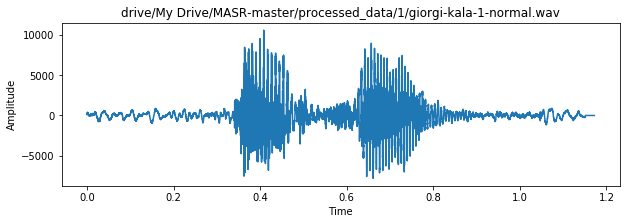

======================================== My Drive ========================================


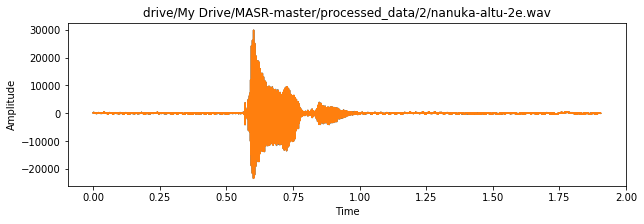

======================================== My Drive ========================================


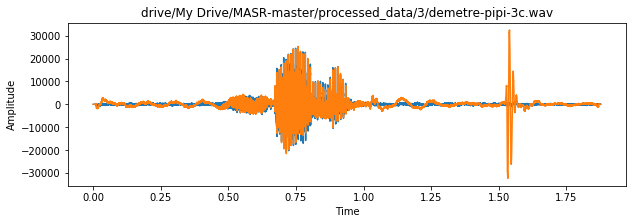

======================================== My Drive ========================================


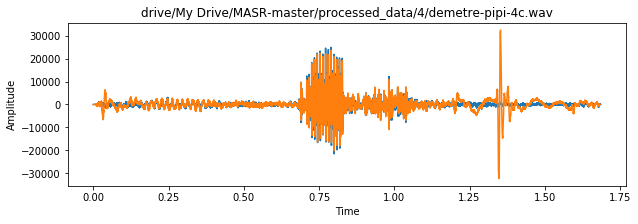

======================================== My Drive ========================================


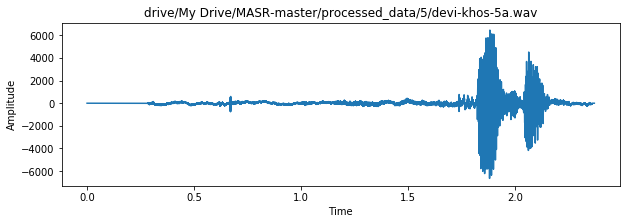

In [108]:
plot_all_spectrograms()

In [0]:
"""IF WANT ADDING NAMES OF RECORDER PEOPLE UNCOMMENT INNER LOOPS"""

def load_data(data_path=processed_data_file_paths, mask=0):
    """ Loads .wav sounds from passed paths into pandas.DataFrame,
        fills shorter sounds with specified mask

        Params:
        data_path   - (list of strings) list containing all paths to files to load
        mask        - (Number) mask is value of filling shorter sounds to match length of longest

        Returns: pands.DataFrame with colums 
            'target'        - (float64) recorded number
            'sound_length'  - (float64) column index where masking starts
            'sampling_rate' - (float64) sampling rate of recording (https://techterms.com/definition/sample_rate) 
             next col names are 0 . . . max sound length in files
    """
    counter = 0
    data = []
    for dir_name in data_path:
        target = int(dir_name.split('/')[-1]) 
        for fname in os.listdir(dir_name):
            # load vound file
            sample, sampling_rate = librosa.load(dir_name+'/'+fname)
            # prepend sampling rate
            sample = np.append(sampling_rate, sample)
            # prepend length of sound file
            sample_length = sample.shape[0]
            sample = np.append(sample_length, sample)
            # prepend target of sample
            sample = np.append(target, sample)
            data.append(sample)
            # recorder_first_name = # get recorder first name
            # recorder_last_name = # get recorder last name
            # sample = np.append(recorder_first_name, sample)
            # sample = np.append(recorder_last_name, sample)
            counter += 1
            if counter % 100 == 0:
                print(counter, '- voices loaded')
    
    data = pd.DataFrame(data).fillna(mask)

    # set colum names to more informative names
    row_specifications = {0: "target", 1: "sound_length", 2: "sampling_rate"}
    sound_specification = { col_indx: str(int(col_indx) - len(row_specifications)) for col_indx in data.columns[len(row_specifications):]}
    column_names = {**row_specifications, **sound_specification}
    data.rename(columns=column_names, inplace=True)
    
    # change types of target length and rate
    col_types = {'target': 'int64', 'sound_length': 'int64', 'sampling_rate': 'int64'}
    data = data.astype(col_types)
    
    return data
            

In [124]:
data = load_data(processed_data_file_paths)

100 - voices loaded
200 - voices loaded
300 - voices loaded
400 - voices loaded
500 - voices loaded
600 - voices loaded


In [125]:
data.head()

,target,sound_length,sampling_rate,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,81752,81753,81754,81755,81756,81757,81758,81759,81760,81761,81762,81763,81764,81765,81766,81767,81768,81769,81770,81771,81772,81773,81774,81775,81776,81777,81778,81779,81780,81781,81782,81783,81784,81785,81786,81787,81788,81789,81790,81791
0,1,54753,22050,-0.000148,-0.000452,-0.000311,-0.000291,-0.000252,-0.000174,-0.000112,-0.000054,-0.000068,-0.000004,-0.000098,-0.000067,-0.000107,-0.000170,-0.000149,-0.000126,-0.000257,-0.000191,-0.000271,-0.000347,-0.000334,-0.000386,-0.000125,-0.000218,-0.000329,-0.000097,-0.000197,-0.000057,0.000090,0.000167,0.000061,-0.000037,0.000138,0.000074,0.000016,0.000045,-0.000101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,49633,22050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,46071,22050,-0.000673,-0.000707,-0.000184,-0.000650,-0.000609,-0.000343,-0.000510,-0.000595,-0.000309,-0.000811,-0.000819,0.000062,0.000411,0.000335,0.000835,0.001026,0.000803,0.000884,0.001053,0.001108,0.000799,0.001060,0.000702,0.000021,-0.000150,-0.000063,-0.000220,-0.000697,-0.000262,0.000266,0.000899,0.001609,0.001631,0.001580,0.001787,0.001587,0.001728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,36222,22050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,30577,22050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
data.info

<bound method DataFrame.info of      target  sound_length  sampling_rate         0  ...  81788  81789  81790  81791
0         1         54753          22050 -0.000148  ...    0.0    0.0    0.0    0.0
1         1         49633          22050  0.000000  ...    0.0    0.0    0.0    0.0
2         1         46071          22050 -0.000673  ...    0.0    0.0    0.0    0.0
3         1         36222          22050  0.000000  ...    0.0    0.0    0.0    0.0
4         1         30577          22050  0.000000  ...    0.0    0.0    0.0    0.0
..      ...           ...            ...       ...  ...    ...    ...    ...    ...
654       5         46571          22050  0.000000  ...    0.0    0.0    0.0    0.0
655       5         29637          22050  0.000000  ...    0.0    0.0    0.0    0.0
656       5         39515          22050  0.000000  ...    0.0    0.0    0.0    0.0
657       5         38104          22050  0.000000  ...    0.0    0.0    0.0    0.0
658       5         46593          22050  0.

In [0]:
CSV_DATA = 'csv_data/sound_data_csv'
data.to_csv(path_or_buf=ROOT+CSV_DATA, index=False)

In [0]:
kata = pd.read_csv(ROOT+CSV_DATA)

In [129]:
kata.head()

,target,sound_length,sampling_rate,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,81752,81753,81754,81755,81756,81757,81758,81759,81760,81761,81762,81763,81764,81765,81766,81767,81768,81769,81770,81771,81772,81773,81774,81775,81776,81777,81778,81779,81780,81781,81782,81783,81784,81785,81786,81787,81788,81789,81790,81791
0,1,54753,22050,-0.000148,-0.000452,-0.000311,-0.000291,-0.000252,-0.000174,-0.000112,-0.000054,-0.000068,-0.000004,-0.000098,-0.000067,-0.000107,-0.000170,-0.000149,-0.000126,-0.000257,-0.000191,-0.000271,-0.000347,-0.000334,-0.000386,-0.000125,-0.000218,-0.000329,-0.000097,-0.000197,-0.000057,0.000090,0.000167,0.000061,-0.000037,0.000138,0.000074,0.000016,0.000045,-0.000101,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,49633,22050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,46071,22050,-0.000673,-0.000707,-0.000184,-0.000650,-0.000609,-0.000343,-0.000510,-0.000595,-0.000309,-0.000811,-0.000819,0.000062,0.000411,0.000335,0.000835,0.001026,0.000803,0.000884,0.001053,0.001108,0.000799,0.001060,0.000702,0.000021,-0.000150,-0.000063,-0.000220,-0.000697,-0.000262,0.000266,0.000899,0.001609,0.001631,0.001580,0.001787,0.001587,0.001728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,36222,22050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,30577,22050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
kata['sound_length'].describe()

count      659.000000
mean     36790.206373
std      11021.568152
min       9185.000000
25%      29637.000000
50%      35841.000000
75%      43521.000000
max      81793.000000
Name: sound_length, dtype: float64

In [131]:
os.listdir(ROOT + CSV_DATA)

NotADirectoryError: ignored

In [147]:
!git add .
!git commit -m "sounds converted to csv"
!git remote add origin https://<zvikiNozadze>:<0badbanana>github@github.com/<zvikiNozadze>/MASR.git
!git push

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
/bin/bash: zvikiNozadze: No such file or directory
fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


In [148]:
!ls -a

csv_data  data	.ipynb_checkpoints  masr.ipynb	processed_data	README.md


In [140]:
!cd drive
!ls

csv_data  drive  sample_data


In [0]:
os.chdir('MASR-master')